In [4]:
# %matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colormaps


from astropy.io import fits
from IPython.display import HTML
from hcipy import *

import sys
# sys.path.append('/home/jliberman/github_repos/magaox-iefc-sim/')
sys.path.append('/home/jasper/Documents/HCIPy_scripts/magaox-iefc-sim/')
# plt.style.use('spieposter')

from iefc_utils import *

# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
# rc('font',**{'family':'serif','serif':['Palatino']})
# rc('text', usetex=True)


# from magsimpyx import make_magaox_bump_mask   # TODO: Get magsimpyx import to work

PLOT_DIR = '/home/jasper/Documents/HCIPy_scripts/magaox-iefc-sim/FPM_shift/'

plt.style.use('spieposter')
# PLOT_DIR = '/home/jliberman/github_repos/magaox-iefc-sim/DM_shift/'

# /home/jliberman/github_repos/magaox-iefc-sim/Lyot_shift/Images

In [5]:
# Set units

magnification_factor = (9*1e-3)/6.5
pupil_diameter = 6.5
# effective_focal_length = 71.5 
wavelength = 750e-9 # m
effective_focal_length = 1

spatial_resolution = wavelength / pupil_diameter
sr = spatial_resolution

# Set up pupil/focal grids
# mpl.rcParams['figure.dpi'] = 100


pupil_grid = make_pupil_grid(512, diameter=3*pupil_diameter)    # Pad the grid to offer a bit more room
# pupil_grid = make_pupil_grid(256, diameter=pupil_diameter)
focal_grid = make_focal_grid(q=5, num_airy=25, spatial_resolution = wavelength/pupil_diameter)
# Create CG focal grid to oversample CG
coro_focal_grid = make_focal_grid(q=32, num_airy=4, spatial_resolution = wavelength/pupil_diameter)
prop = FraunhoferPropagator(pupil_grid, focal_grid, focal_length=effective_focal_length)


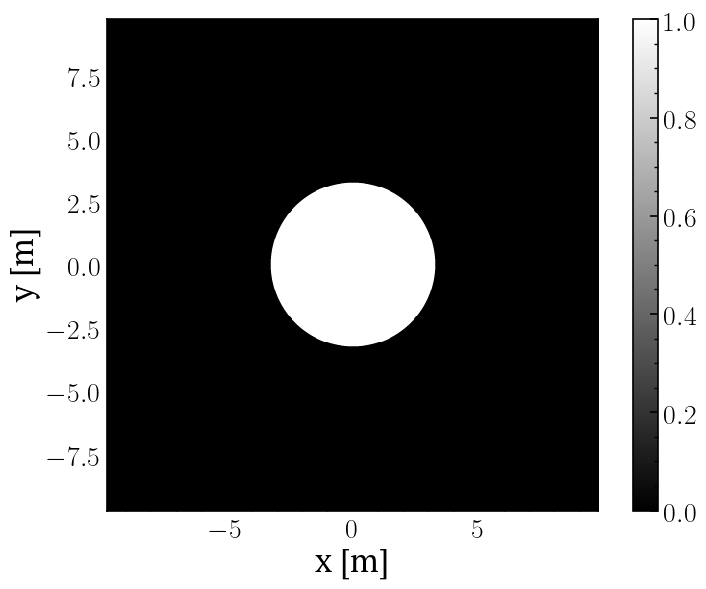

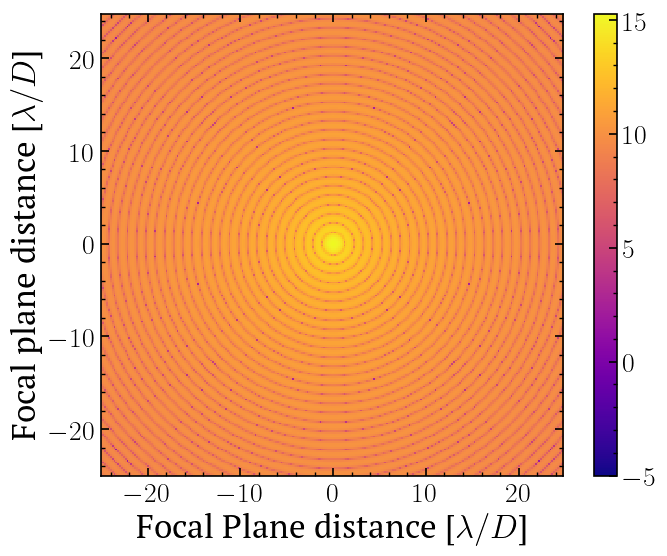

In [6]:
# Plot the bump mask scaled up to MagAO-X pupil diameter

# offset = 0.0
# bump_mask_offset = [offset*pupil_diameter, 0]


# Plot the bump mask scaled up to MagAO-X pupil diameter

telescope_pupil_circ = evaluate_supersampled(make_circular_aperture(pupil_diameter), pupil_grid, 4)

# telescope_pupil_mag = evaluate_supersampled(make_rotated_aperture(make_magaox_bump_mask(), np.pi/2), pupil_grid, 4)


# Plot telescope  pupil
imshow_field(telescope_pupil_circ, cmap='gray',)
plt.colorbar()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.tight_layout()
# plt.savefig('../mag_ap.svg', transparent=True)
plt.show()

wavefront = Wavefront(telescope_pupil_circ, wavelength)

focal_image = prop.forward(wavefront)

norm = focal_image.power.max()

# Plot PSF
imshow_field(np.log10(focal_image.intensity / norm), vmin=-5, grid_units=sr)
# save_field('magellan_pup.svg', np.log10(focal_image.intensity / norm))
plt.xlabel('Focal Plane distance [$\lambda / D$]')
plt.ylabel('Focal plane distance [$\lambda / D$]')
plt.colorbar()
plt.show()


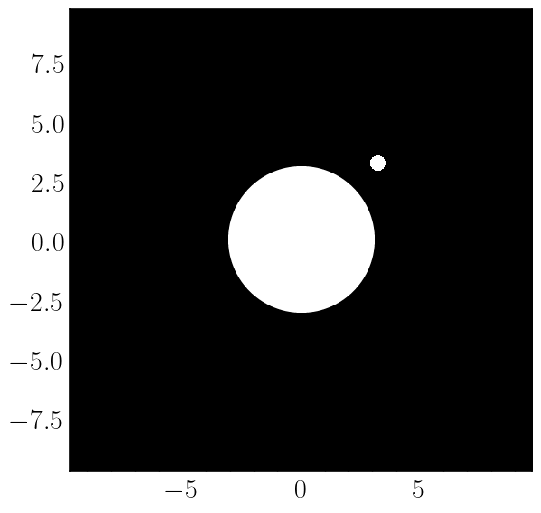

In [7]:
     # Generate slightly undersized Lyot Stop                   
lyot_mask = evaluate_supersampled(make_circular_aperture(0.95*pupil_diameter), pupil_grid, 4)

pinhole_diameter = 0.5742e-3 # TODO: Ask about this...

# Add pinhole to Lyot mask 
pinhole_pos = .7 * np.array([pupil_diameter/np.sqrt(2), pupil_diameter/np.sqrt(2)])
pinhole = make_circular_aperture(0.1*pupil_diameter, center=pinhole_pos)

scc_mask = lyot_mask * (1-pinhole(pupil_grid)) + pinhole(pupil_grid)

# Plot SCC mask
imshow_field(scc_mask, cmap='gray')
plt.show()

scc_stop = Apodizer(scc_mask)

lyot_stop = Apodizer(lyot_mask)


In [8]:
# ######## Initialize Lyot CG
# center_pos = np.array([0*pupil_diameter, 0]) # Pupil plane shift is defined in percentage of the pupil
# lyot_mask_imperfect = evaluate_supersampled(make_circular_aperture(0.95*pupil_diameter, center=center_pos), pupil_grid, 4) # Generate undersized Lyot stop
# # Note: This should be opaque!
# focal_plane_mask = 1 - evaluate_supersampled(make_circular_aperture(6*sr), coro_focal_grid, 4) # Define FPM w/ diameter of 6 lambda/D and oversampled CG grid

# lyot_stop = Apodizer(lyot_mask_imperfect)

# # Generate a Lyot CG on the oversample CG grid
# order = 2
# coro_lyot = LyotCoronagraph(pupil_grid, focal_plane_mask, lyot_stop,  focal_plane_mask_grid=coro_focal_grid)


############ Initialize VVC
charge = 6                      # Generate a charge 6 Vortex CG
coro_vortex = VectorVortexCoronagraph(charge, lyot_stop=scc_stop)

########### Initialize Perfect CG
# Generate order 2 perfect CG
# order = 2
# coro_perfect = PerfectCoronagraph(telescope_pupil_circ, order)

In [9]:
#  Construct 1k DM
num_actuators_across_pupil = 34
actuator_spacing = pupil_diameter / num_actuators_across_pupil
influence_functions = make_gaussian_influence_functions(pupil_grid, num_actuators_across_pupil, actuator_spacing, x_tilt=np.rad2deg(45))
deformable_mirror = DeformableMirror(influence_functions)
num_modes = deformable_mirror.num_actuators

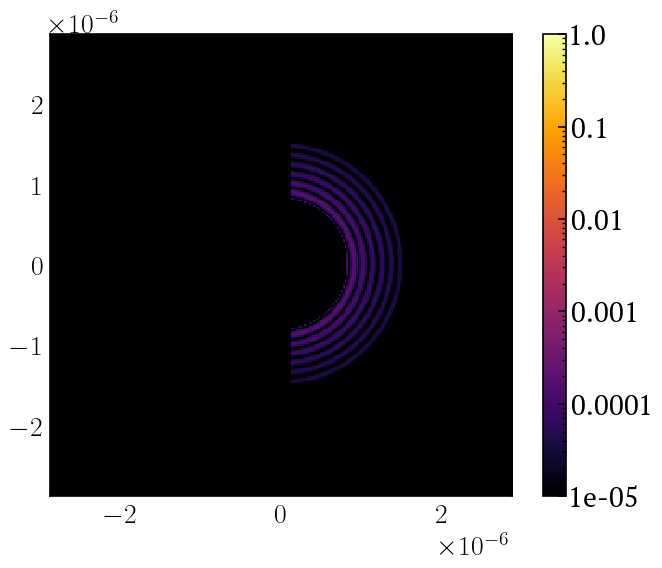

In [10]:
# Define control region

# TODO: Start w/ region further from optical axis---try box at 10 lambda/D, right now I think that modes are behind CG, poorly sensed


Dtel = 6.5
fourier_grid = make_pupil_grid(32, 32)        # Define grid


# fourier_mask = (fourier_grid.as_('polar').r < 10) * (fourier_grid.as_('polar').r > 2)   # Overlay modes from 2-10 lambda/d
# fourier_mask *= fourier_grid.x > 0

# focal_mask = (focal_grid.as_('polar').r < 9*sr) * (focal_grid.as_('polar').r > 3*sr)    # We prev. defined as 1 lambda/D
# focal_mask *= focal_grid.x > 1*sr

# wavefront_mag = Wavefront(telescope_pupil_mag, wavelength)
wavefront_circ = Wavefront(telescope_pupil_circ, wavelength)

# focal_image = prop.forward(wavefront)

fourier_mask = (fourier_grid.as_('polar').r < 14) * (fourier_grid.as_('polar').r > 6)   # Overlay modes from 6-14 lambda/d
fourier_mask *= fourier_grid.x > 0

focal_mask = (focal_grid.as_('polar').r < 13*sr) * (focal_grid.as_('polar').r > 7*sr) 
focal_mask *= focal_grid.x > 1*sr

# focal_image_mag = prop.forward(wavefront_mag)
focal_image_circ = prop.forward(wavefront_circ)

# dark_hole_pixels_mag = focal_image_mag.power*focal_mask # Apply DH mask to image
dark_hole_pixels_circ = focal_image_circ.power*focal_mask



imshow_psf(dark_hole_pixels_circ/focal_image_circ.power.max() + 1e-16, vmax=1, vmin=1e-5)
plt.show()

fourier_basis = make_fourier_basis(pupil_grid, fourier_grid.scaled(2 * np.pi / Dtel))   

# Select Fourier modes that fall within DH
selected_modes = fourier_grid.subset(fourier_mask>0)     

fourier_basis_selected = make_fourier_basis(pupil_grid, selected_modes.scaled(2 * np.pi / Dtel))   # Basis w/ seelected Fourier modes from control region

fourier_dm = DeformableMirror(fourier_basis)
fourier_dm_selected = DeformableMirror(fourier_basis_selected)  # Create DM w/ only the selected modesw from control region

In [11]:
# # Determine where actuator falls wrt pupil and define probes

# fourier_dm.flatten()

# probe_amp = 0.01 * wavelength

# wf = Wavefront(telescope_pupil_mag, wavelength) # Reference WF
# wf.total_power = 1

# norm = prop(wf).power.max() # Normalize w/ unaberrated WF

# # Apply sin wave to DM
# # fourier_dm.actuators[20] += probe_amp        

#  # Propagate WF through system
# dm_wf = fourier_dm.forward(wf) # WF after DM
# lyot_wf = coro_lyot(wf) # WF in the Lyot Plane
# psf = prop(lyot_wf).power

# imshow_psf(psf / norm, vmax=1, vmin=1e-5)
# # imshow_psf(prop(dm_wf).power / norm, vmax=1, vmin=1e-5)

# plt.show()

In [ ]:
############ Initialize VVC
charge = 6                      # Generate a charge 6 Vortex CG
coro_vortex = VectorVortexCoronagraph(charge, lyot_stop=scc_stop)

In [ ]:
# Initialize vars for Jacobian

optical_system_scc_vort = OpticalSystem([coro_vortex, scc_stop, prop])
optical_system_vort = OpticalSystem([coro_vortex, lyot_stop, prop])

wf_vortex = Wavefront(telescope_pupil_circ, wavelength)
sa = SurfaceAberration(pupil_grid, 0.1*wavelength, pupil_diameter)


# optical_system_perfect = OpticalSystem([coro_perfect, prop])
# wf_perfect = Wavefront(telescope_pupil_circ, wavelength)

# optical_system_lyot = OpticalSystem([coro_lyot, lyot_stop, prop])
# wf_lyot = wf_perfect.copy()


In [ ]:
wf_coronagraph_ab = coro_vortex(sa(wf_vortex))

wf_lyot = lyot_stop(wf_coronagraph_ab)

img_lyot = prop(wf_lyot).power

wf_scc = scc_stop(wf_coronagraph_ab)
img_scc = prop(wf_scc).power



In [10]:
    # # Jacobian (iEFC)

    ######## NEW GITHUB VERSION ##########################

probe_amp = 0.01 * wavelength # Set a probe amplitude
calibration_amp = 0.01 * wavelength


# wf = Wavefront(telescope_pupil, wavelength) # Reference WF

num_modes = fourier_dm_selected.num_actuators # Excite only the modes that fall within control region

# response_matrices_selected = np.zeros((num_modes, 5700)) # Initialize empty vector of slopes


amps = np.ones(num_modes) * probe_amp

deformable_mirror.flatten()
fourier_dm_selected.flatten()

#### DEBUGGING: JUST GENERATE JAC FOR ONE CG RIGHT N0W

# for coro_idx, coro in enumerate(coro_list):
#     if coro == coro_vortex:
#         wf = Wavefront(telescope_pupil_circ, wavelength) # Reference WF
#     else:
#         wf = Wavefront(telescope_pupil_mag, wavelength)
    
#     optical_system = OpticalSystem([coro, lyot_stop, prop])

optical_system = OpticalSystem([coro_vortex, lyot_stop, prop])

wf = Wavefront(telescope_pupil_circ, wavelength) # Reference WF

    
# wf = Wavefront(telescope_pupil_mag, wavelength) # Reference WF

# coro_perfect = PerfectCoronagraph(telescope_pupil_mag, order)



    
scc_sensor = make_scc_sensor(probe_1=400, probe_2=401, probe_amp=0.01*wavelength, dm=deformable_mirror, optical_system=optical_system)

# print(coro)
for ind in range(num_modes):
    if ind % 10 == 0:
        print('Measure response to mode {:d} / {:d}'.format(ind + 1, num_modes))
    
    calibration_images = []
    for cal_amp in [-calibration_amp, calibration_amp]:

        # Add the mode that we are calibrating
        fourier_dm_selected.actuators[ind] += cal_amp #  (Fourier DM) Ensure that we are only calibrating modes that fall on the pupil

        diff_images = pwp_sensor(fourier_dm_selected(wf))  # Perform PWP

        # if coro == coro_vortex:
        #     pwp_measurement = extract_measurement_from_difference_images(diff_images, dark_hole_pixels_circ>0) # Extract diff image measurements for DH region
        # else:
        #     pwp_measurement = extract_measurement_from_difference_images(diff_images, dark_hole_pixels_mag>0) # Extract diff image measurements for DH region

        pwp_measurement = extract_measurement_from_difference_images(diff_images, dark_hole_pixels_mag>0) # Extract diff image measurements for DH region
        
        calibration_images.append(pwp_measurement)

        # Remove the mode that we are calibrating
        fourier_dm_selected.actuators[ind] -= cal_amp

    slope =  ((calibration_images[1] - calibration_images[0])/(2*calibration_amp)) # Construct slope vector

    # response_matrices_selected[ind] = slope
    response_matrices_selected.append(slope) # Append slope vector to response matrix

response_matrices_selected_arr = np.array(response_matrices_selected)

# /home/jliberman/github_repos/magaox-iefc-sim/Lyot_shift/jacobians_threeCGs.npy



Measure response to mode 1 / 504
Measure response to mode 11 / 504
Measure response to mode 21 / 504
Measure response to mode 31 / 504
Measure response to mode 41 / 504
Measure response to mode 51 / 504
Measure response to mode 61 / 504
Measure response to mode 71 / 504
Measure response to mode 81 / 504
Measure response to mode 91 / 504
Measure response to mode 101 / 504
Measure response to mode 111 / 504
Measure response to mode 121 / 504
Measure response to mode 131 / 504
Measure response to mode 141 / 504
Measure response to mode 151 / 504
Measure response to mode 161 / 504
Measure response to mode 171 / 504
Measure response to mode 181 / 504
Measure response to mode 191 / 504
Measure response to mode 201 / 504
Measure response to mode 211 / 504
Measure response to mode 221 / 504
Measure response to mode 231 / 504
Measure response to mode 241 / 504
Measure response to mode 251 / 504
Measure response to mode 261 / 504
Measure response to mode 271 / 504
Measure response to mode 281 / 

In [9]:
# # TODO: DeBUGGING...

# # coro_list = [coro_perfect, coro_lyot, coro_vortex]    # Debugging

# coro_list = [coro_perfect, coro_vortex]

#     # # Jacobian (iEFC)

#     ######## NEW GITHUB VERSION ##########################

# probe_amp = 0.01 * wavelength # Set a probe amplitude
# calibration_amp = 0.01 * wavelength


# # wf = Wavefront(telescope_pupil, wavelength) # Reference WF

# num_modes = fourier_dm_selected.num_actuators # Excite only the modes that fall within control region

# response_matrices_selected = np.zeros(((len(coro_list), num_modes, 5700))) # Initialize empty vector of slopes


# amps = np.ones(num_modes) * probe_amp

# deformable_mirror.flatten()
# fourier_dm_selected.flatten()

# #### DEBUGGING: JUST GENERATE JAC FOR ONE CG RIGHT N0W

# # for coro_idx, coro in enumerate(coro_list):
# #     if coro == coro_vortex:
# #         wf = Wavefront(telescope_pupil_circ, wavelength) # Reference WF
# #     else:
# #         wf = Wavefront(telescope_pupil_mag, wavelength)
    
# #     optical_system = OpticalSystem([coro, lyot_stop, prop])

# for coro_idx, coro in enumerate(coro_list):
#     if coro == coro_vortex:
#         optical_system = OpticalSystem([coro, lyot_stop, prop])
#     else:
#         optical_system = OpticalSystem([coro, prop])

#     wf = Wavefront(telescope_pupil_circ, wavelength) # Reference WF



        
#     pwp_sensor = make_pairwise_probing_sensor(probe_1=400, probe_2=401, probe_amp=0.01*wavelength, dm=deformable_mirror, optical_system=optical_system)

#     print(coro)
#     for ind in range(num_modes):
#         if ind % 10 == 0:
#             print('Measure response to mode {:d} / {:d}'.format(ind + 1, num_modes))
        
#         calibration_images = []
#         for cal_amp in [-calibration_amp, calibration_amp]:

#             # Add the mode that we are calibrating
#             fourier_dm_selected.actuators[ind] += cal_amp #  (Fourier DM) Ensure that we are only calibrating modes that fall on the pupil

#             diff_images = pwp_sensor(fourier_dm_selected(wf))  # Perform PWP

#             # if coro == coro_vortex:
#             #     pwp_measurement = extract_measurement_from_difference_images(diff_images, dark_hole_pixels_circ>0) # Extract diff image measurements for DH region
#             # else:
#             #     pwp_measurement = extract_measurement_from_difference_images(diff_images, dark_hole_pixels_mag>0) # Extract diff image measurements for DH region

#             pwp_measurement = extract_measurement_from_difference_images(diff_images, dark_hole_pixels_circ>0) # Extract diff image measurements for DH region
            
#             calibration_images.append(pwp_measurement)

#             # Remove the mode that we are calibrating
#             fourier_dm_selected.actuators[ind] -= cal_amp

#         slope =  ((calibration_images[1] - calibration_images[0])/(2*calibration_amp)) # Construct slope vector

#         response_matrices_selected[coro_idx][ind] = slope
#         # response_matrices_selected.append(slope) # Append slope vector to response matrix

# response_matrices_selected_arr = np.array(response_matrices_selected)

# # /home/jliberman/github_repos/magaox-iefc-sim/Lyot_shift/jacobians_threeCGs.npy



In [11]:
np.save('./jacobian_twoCGs_mag_ap.npy', response_matrices_selected_arr)


In [12]:
num_modes = fourier_dm_selected.num_actuators # Excite only the modes that fall within control region


# Load Jacobian
# coro_list = [coro_perfect, coro_lyot, coro_vortex]
coro_list = [coro_perfect, coro_lyot]


# coro_list = [coro_vortex]
resp_mat_sel = response_matrices_selected_arr

# plt.imshow(response_matrices_selected[0], aspect='auto')
# plt.colorbar()
# plt.show()

# Compute reconstruction matrix
rcond = 2e-3

reconstruction_matrices_selected = np.zeros(((len(coro_list), num_modes, 5700))) # Initialize empty vector of reconstruction matrices

resp_mat_sel.shape

reconstruction_matrices_selected.shape

for idx, resp in enumerate(resp_mat_sel): 
    reconstruction_matrices_selected[idx] = inverse_tikhonov(resp.T, rcond=rcond, svd=None) # Feed in response matrix for DH modes


# reconstruction_matrices_selected = inverse_tikhonov(resp_mat_sel.T, rcond=rcond, svd=None) # Feed in response matrix for DH modes

In [13]:
np.save('./rec_mat_twoCGs_mag_ap.npy', reconstruction_matrices_selected)
